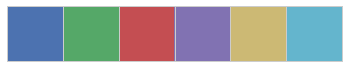

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns
%matplotlib inline
from astroML.plotting import setup_text_plots
pd.options.mode.chained_assignment = None
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [20]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [3]:
df=pd.read_csv('HyperLeda_a007_full.txt',skiprows=19,skipfooter=5,names=['objname','j2000','modulus','distance','modc','method','ire','bibref','bibcode','calib'])
df['mod']=np.array([i[0:5] for i in np.array(df.modulus,dtype='str')],dtype='float')
df['err']=np.array([i[6:10] for i in np.array(df.modulus,dtype='str')])
df=df.replace('    ',np.nan)
df.err=df.err.astype(float)
df.head()

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,objname,j2000,modulus,distance,modc,method,ire,bibref,bibcode,calib,mod,err
0,PGC000143,J000158.2-152739,24.88 0.09,0.946 0.040,24.88,CMD,51357,Dolphin2000,,None,24.88,0.09
1,PGC000143,J000158.2-152739,24.84 0.14,0.929 0.062,24.84,Cepheids,51351,Valcheva+2007,,None,24.84,0.14
2,PGC000143,J000158.2-152739,24.92 0.21,0.964 0.098,24.92,Cepheids,51332,Sakai+2004,,None,24.92,0.21
3,PGC000143,J000158.2-152739,24.92 0.07,0.966 0.033,24.92,Cepheids,51352,Gieren+2008,,None,24.92,0.07
4,PGC000143,J000158.2-152739,24.93,0.968,24.93,Cepheids,51353,Sandage+1985,,None,24.93,NaN


In [28]:
filter=(np.isnan(df.err))|(df.err==0)
elist=np.unique(df.objname[filter])

In [17]:
df1=df[~filter]
namelist=np.unique(df1.objname)

In [21]:
%%time
np.random.seed(10)
nbins=100 # 1e4 -> 1 minutes
em=[] # number of measurements per galaxy
bootp50=[] # mean error from the bootstrap for each galaxy
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
boot84=[]
boot16=[]
ecf=[]
eqd=[]
pos=[]
gal=[]
for i in namelist:
    dfilter=np.in1d(df1['objname'],i)
    dummy=df1[dfilter]
    if len(dummy)>1:
        em+=[len(dummy)] # n_meas, number of measurements per galaxy
        pos+=[dummy.j2000.iloc[0]]
        gal+=[dummy.objname.iloc[0]]
        tli=[]
        for km,ke in zip(dummy['modc'],dummy['err']):
            tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
        tli=np.array(tli)
        b84=np.percentile(tli, 84,axis=0)
        b16=np.percentile(tli, 16,axis=0)
        boot84+=[np.median(b84)/1e6] # Hmax
        boot16+=[np.median(b16)/1e6] # Hmin
        booterr=(b84-b16)/2 # sigma draws from bootstrap for each gal
        bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
        bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
        bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
        bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
        dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
        wnat,avnat = weighted_std(dummy['modc'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)/1e6
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        ecf+=[ecfi]
        eqd+=[np.sqrt(ecfi**2+wsti**2)]  

CPU times: user 6.3 s, sys: 0 ns, total: 6.3 s
Wall time: 6.32 s


In [30]:
print('No. of Galaxies with reported errors is %i' % len(namelist) )
print('No. of Galaxies with more than 1 measurement is %i' % len(em) )
print('No. of Galaxies without reported errors is %i' % len(elist) )

No. of Galaxies with reported errors is 3999
No. of Galaxies with more than 1 measurement is 2456
No. of Galaxies without reported errors is 1064


In [35]:
d = {'objname': gal,'j2000':pos, 'meas': em, 'H (Mpc)':bootp50, 'D (Mpc)':dboot,'P (Mpc)':ecf,'Q (Mpc)':eqd,'M (Mpc)':bootmad,'Dmin (Mpc)':boot16,'Dmax (Mpc)':boot84}
dfb = pd.DataFrame(data=d)
dfb.to_csv("hl_bootstrap_results.csv")

In [ ]:
# percentiles?

### Start here if you have bootstrap results already

In [45]:
dfb=pd.read_csv('hl_bootstrap_results.csv')

In [46]:
em=dfb.meas
dboot=dfb['D (Mpc)']
bootp50=dfb['H (Mpc)']
ecf=dfb['P (Mpc)']
eqd=dfb['Q (Mpc)']
bootmad=dfb['M (Mpc)']

In [47]:
filt=np.array(em)<3
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

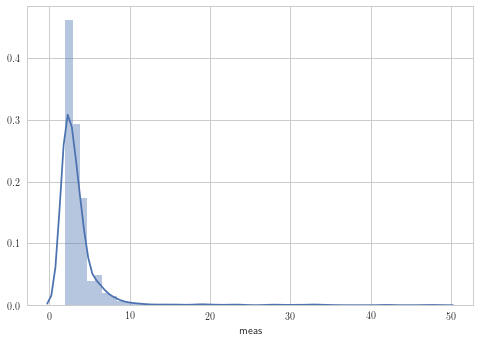

In [48]:
sns.distplot(em) 

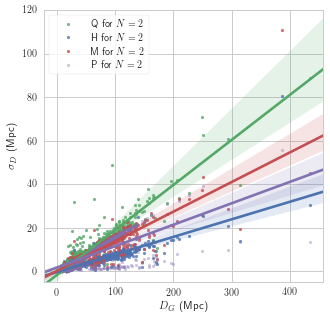

In [49]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N=2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N=2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N=2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N=2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)
plt.savefig('mnras/HLlow.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/HLlow.png', dpi=reso,transparent=True)

(-5, 120)

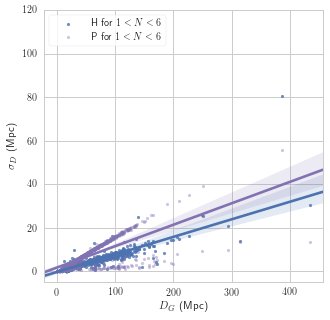

In [50]:
plt.figure(figsize=(5,5))
sns.regplot(x,y,color=current_palette[0],label=r'H for $1<N<6$', scatter_kws={'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $1<N<6$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)

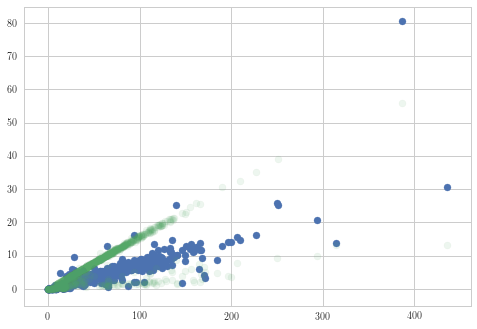

In [51]:
plt.scatter(x,y)
plt.scatter(x,cf,alpha=0.1)

In [52]:
filt=np.array(em)>2
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]

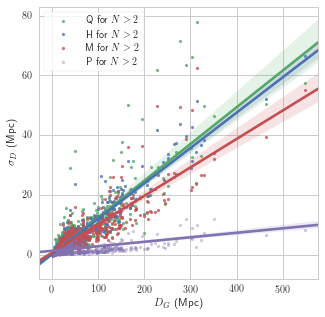

In [53]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
#plt.ylim(0,15)
plt.savefig('mnras/HLhigh.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/HLhigh.png', dpi=reso,transparent=True)

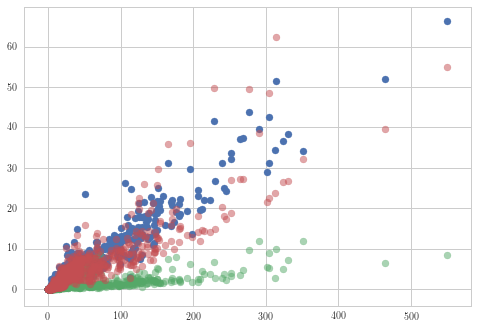

In [54]:
plt.scatter(x,y)
plt.scatter(x,cf,alpha=0.5)
plt.scatter(x,z,alpha=0.5)

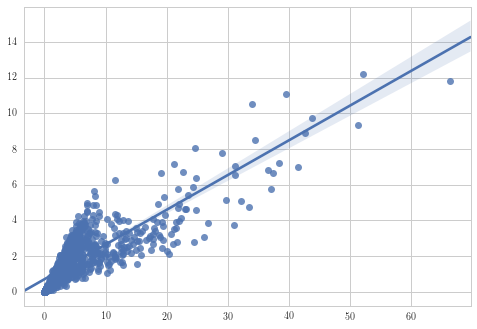

In [55]:
# this only works if bootstrap is done within the notebook
ee=np.array(bootsig)[filt] 
sns.regplot(y,ee)

In [63]:
odf=df[df.method=='TF        ']
filter=(np.isnan(odf.err))|(odf.err==0)
odf=odf[filter]
oelist=np.unique(odf.objname)

In [64]:
print('No. of Galaxies without reported TF errors is %i' % len(oelist) )

No. of Galaxies without reported TF errors is 203


In [65]:
meddist=[]
for i in oelist:
    dummy=odf[odf['objname']==i]
    meddist+=[np.median(10**(dummy.modc/5+1)/1e6)]
meddist=np.array(meddist)

In [67]:
x1=np.array([3.2233139166587161, 140.96666964288357])
filt1=(meddist<x1.max())&(meddist>x1.min())
(filt1).sum() # galaxies in range

200

In [68]:
x2=np.array([2.8327613702075238, 140.96666964288357])
filt2=(meddist<x2.max())&(meddist>x2.min())
(filt2).sum() # galaxies in range

200

In [69]:
samples1=np.loadtxt('posterior_lh.txt')
samples2=np.loadtxt('posterior_lm.txt')

In [70]:
sth1=np.median(samples1,axis=0)
sth2=np.median(samples2,axis=0)

In [71]:
bfilt=dfb.meas>2
x=dfb['D (Mpc)'][bfilt]
y=dfb['H (Mpc)'][bfilt]
z=dfb['M (Mpc)'][bfilt]

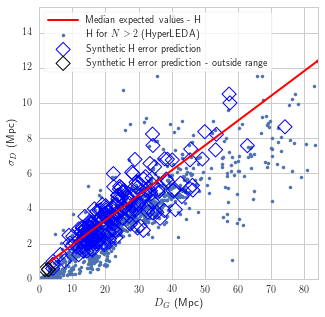

In [93]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,y,s=10,label='H for $N>2$ (HyperLEDA)')
xp=np.linspace(x1.min(),x1.max(),2)
modpar=samples1[np.random.randint(len(samples1))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x1,y1,label='H for $N>15$ measurements')
mark='D'
plt.scatter(meddist[filt1],ysim[filt1], linewidth='1', facecolors='none', edgecolors='b',s=100,marker=mark,label='Synthetic H error prediction')
plt.scatter(meddist[~filt1],ysim[~filt1], linewidth='1', facecolors='none', edgecolors='k',s=100,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth1[0]+sth1[1],c='r',linewidth=2,label='Median expected values - H')
plt.xlim(0,meddist.max()+10)
plt.ylim(0,(xp*sth1[0]+sth1[1]).max()-5)
plt.legend(frameon=True,loc='upper left')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predhl1.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predhl1.png', dpi=reso,transparent=True)

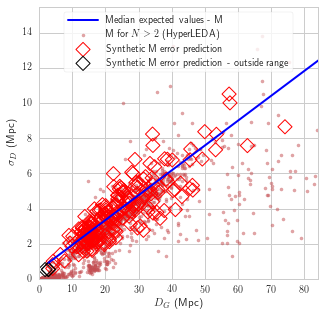

In [92]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,z,c=current_palette[2],s=10,label='M for $N>2$ (HyperLEDA)',alpha=0.5)
xp=np.linspace(x2.min(),x2.max(),2)
modpar=samples2[np.random.randint(len(samples2))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x2,y2,c=current_palette[1],label='M for $N>13$ measurements')
mark='D'
plt.scatter(meddist[filt2],ysim[filt2], linewidth='1', facecolors='none', edgecolors='r',s=100,marker=mark,label='Synthetic M error prediction')
plt.scatter(meddist[~filt2],ysim[~filt2], linewidth='1', facecolors='none', edgecolors='k',s=100,marker=mark,label='Synthetic M error prediction - outside range')
plt.plot(xp,xp*sth2[0]+sth2[1],c='b',linewidth=2,label='Median expected values - M')
plt.xlim(0,meddist.max()+10)
plt.ylim(0,(xp*sth2[0]+sth2[1]).max()-5)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predhl2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predhl2.png', dpi=reso,transparent=True)